#Mout Drive

In [1]:
# Mout Google Drive
# https://towardsdatascience.com/google-drive-google-colab-github-dont-just-read-do-it-5554d5824228
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT)
# %pwd %ls

Mounted at /content/drive


#Commit Changes to Git

In [5]:
%run /content/drive/MyDrive/CNNStanford/pytorch/pytorch_sandbox/Colab_Helper.ipynb

mkdir: cannot create directory ‘/content/drive/My Drive/CNNStanford/pytorch’: File exists
PROJECT_PATH: /content/drive/My Drive/CNNStanford/pytorch
/content/drive/My Drive/CNNStanford/pytorch/pytorch_sandbox


In [6]:
MESSAGE = "clean comments"
!git config --global user.email "ronyginosar@mail.huji.ac.il"
!git config --global user.name "ronyginosar"
!git add .

In [7]:
!git commit -m "{MESSAGE}"
!git push "{GIT_PATH}"

[main 100a5b5] clean comments
 1 file changed, 1 insertion(+), 1 deletion(-)
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 2 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 2.37 KiB | 127.00 KiB/s, done.
Total 7 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 3 local objects.
To https://github.com/ronyginosar/pytorch_sandbox.git
   7f7f204..100a5b5  main -> main


#Code Section

In [ ]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

1. Create a tensor of size 3x120x160, representing an RGB image.

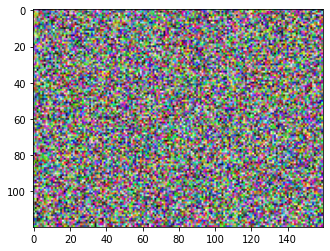

In [ ]:
# %% 1. Create a tensor of size 3x120x160, representing an RGB image.
# The tensor should have integer values uniformly distributed between 0 and 255
# hint: torch.randint
color_range = 255
in_channels = 3
x = torch.randint(high=color_range, size=(in_channels, 120, 160))
plt.imshow(x.permute(1, 2, 0))
plt.show()

2. Write a function that randomly crops a PxP patch from a 3D tensor (CxHxW)
and returns a 3D tensor patch (CxPxP)

In [ ]:
# %% 2. Write a function that randomly crops a PxP patch from a 3D tensor (CxHxW)
# and returns a 3D tensor patch (CxPxP)
# You can assume that  H>P and W>P
# Hint: .shape() , torch.randint, .item() , slicing: t[:, .. , ..]
def random_crop(in_tensor, patch_size):
    import random
    h, w = in_tensor.size(dim=1), in_tensor.size(dim=2)
    h -= patch_size-1  # -1 due to randint range definition
    w -= patch_size-1
    x = random.randint(0, h)
    y = random.randint(0, w)
    out_tensor = in_tensor[:, x:x+patch_size, y:y+patch_size]
    return out_tensor

3. Crop 10 random 5x5 patches (using random_crop) and put them into a list of tensors

Q: Does the cropped patches and the original tensor share the same underlying data?

A:True, it's just a view with slice

In [ ]:
# %% 3. Crop 10 random 5x5 patches (using random_crop) and put them into a list of tensors:
# Question Does the cropped patches and the original tensor share the same underlying data?
# (check for yourself)
# A:True, it's just a view with slice
patches_list = [random_crop(x, 5) for _ in range(10)]

4. Concatenate the 10 3x5x5 tensors into a single 4D tensor 10x3x5x5

In [ ]:
# %% 4. Concatenate the 10 3x5x5 tensors into a single 4D tensor 10x3x5x5
# Hint: torch.stack (note the difference between torch.stack and torch.cat)
# Question Does the batched tensor share the same underlying data as the original input?
# A: False, stack returns new memory
batch = torch.stack(patches_list)

5. Convert to floating point and divide by 255, to get values range between 0 and 1

In [ ]:
# %% 5. Convert to floating point and divide by 255, to get values range between 0 and 1
# Hint: .to()
batch = batch.to(torch.float)/color_range  # this is new data, not changing original

6. Find the mean and std for each channel (R,G,B), across all patches.

In [ ]:
# %% 6. Find the mean and std for each channel (R,G,B), across all patches.
# Hint: torch.mean, torch.std; or torch.std_mean
# channel_mean, channel_std should be 1D vectors with 3 elements each

# channel_std, channel_mean = torch.Tensor([torch.mean(batch[:, i, :, :]) for i in range(3)]), torch.Tensor([torch.std(batch[:, i, :, :]) for i in range(3)])
channel_std, channel_mean = torch.std_mean(batch, dim=(0, 2, 3))

7. Normalize the batch so that each channel (R,G,B) has zero mean and unit std

In [ ]:
# %% 7. Normalize the batch so that each channel (R,G,B) has zero mean and unit std
# Hint: Broadcasting!  To be able to broadcast, use .view() on channel_mean & channel_std
# to add singleton dimensions as necessary
# Make sure that the resulting normalized batch indeed has mean 0, std 1 at each channel

broadcast = (1, in_channels, 1, 1) # or channel_mean.view(-1,1,1)
batch_normalized = (batch - channel_mean.view(broadcast)) / channel_std.view(broadcast)
print(batch_normalized.std(dim=(0, 2, 3)))
print(batch_normalized.mean(dim=(0, 2, 3)))

tensor([1.0000, 1.0000, 1.0000])
tensor([-3.2425e-08, -4.9591e-08, -4.1485e-08])


8. Apply Convolution over the batch, with 16 output channels, kernel size 3x3, padding 1

In [ ]:
# %% 8. Apply Convolution over the batch, with 16 output channels, kernel size 3x3, padding 1
# Hint: use torch.nn.functional.conv2d;
#       create random tensors for the weights (16x3x3x3) and biases (16) (torch.randn)
#       What should be the output shape?
# A: [10, 16, 5, 5] (k is 3)
out_channels = 16
k = 3
weights_conv = torch.randn(size=(out_channels, in_channels, k, k))
biases_conv  = torch.randn(out_channels)
y_conv = F.conv2d(batch_normalized, weights_conv, biases_conv, padding=1)

9. Write LeakyReLU activation function

In [ ]:
# %% 9. Write LeakyReLU activation function
# LeakyReLU(x) = x if x>=0,  negative_slope*x otherwise
# Hint: torch.maximum, torch.minimum, or logical operations (e.g x>=0)
def leaky_relu(x, negative_slope=0.01):
    return torch.maximum(x, x*negative_slope) # or x*(x>=0) + x*negative_slope*(x<0)

10. Apply LeakyReLU on the convolution result

In [ ]:
# %% 10. Apply LeakyReLU on the convolution result
# Compare yourself to the result of nn.functional.leaky_relu.
# Hint - torch.equal
y_act = leaky_relu(y_conv)

tmp = F.leaky_relu(y_conv, negative_slope=0.01)
print(torch.equal(tmp, y_act))

True


11. Apply a Fully Connected layer with 2 outputs

In [ ]:
# %% 11. Apply a Fully Connected layer with 2 outputs
# (a) create a random weights matrix, size Kx2 (what is K?) -> **Kx2** A: 400, 5*5*16=400
# (b) create a random biases vector, size 2
# (c) apply matrix-vector multiplication (using torch.matmul, or '@' symbol), then add the bias.
#  Note that before applying FC, you need to flatten the input tensor by
#  reshaping it to 10xK (hint - torch.view / torch.resize / torch.flatten)
#  What should be the shape of y_out? -> A: 10x2 (2!, not 400...)

# flat_tensor = y_act.view(-1)  # view(-1) is the same as flatten, only view returns a copy
flat_tensor = y_act.view(10, -1)  # **10xK**, not 1D K # option: input_features = torch.tensor(y_act.shape[1:]).prod().item()
K = flat_tensor.shape[1]
# weights_fc = torch.randn(size=(K*2, K*2)) **Kx2**
weights_fc = torch.randn(K, 2)
biases_fc = torch.randn(2)
y_out = torch.matmul(flat_tensor, weights_fc) + biases_fc

12. Calculate MSE over the batch between the output value and "ground truth"

In [ ]:
# %% 12. Calculate MSE over the batch between the output value and "ground truth"
# first, create a fake ground truth by randomly generating the target tensor (10x2)
target = torch.randn(10, 2)
# mse = torch.sum((y_out - target)**2) / 20
mse = torch.mean((y_out - target)**2)
print(mse)

tensor(7295.3267)
